# A template for mapping georeferenced mammal trait data

This template provides a demonstration of how a curated mammal trait dataset (in this case, population density estimates for mammals on islands) can be plotted using matplotlib, clipped to a specified extent, and written to a json file for web mapping. The original data are from the TetraDENSITY dataset (more information <a href="https://doi.org/10.1111/geb.12756">here</a> and data can be accessed <a href="https://figshare.com/articles/dataset/TetraDENSITY_Population_Density_dataset/5371633">here</a>), a global georeferenced dataset of population density estimates for tetrapods. Data used in the following have been curated to only include records from mammals on islands.

## Library Initialization

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Read in and inspect data

In [2]:
mammals = gpd.read_file('data/global_mammal_densities_islands.csv')
land = gpd.read_file('data/ne_50m_land.zip')

Inspect the generated variables to confirm data were read in correctly. Make sure that the data are projected the correct way (in this case, we are using epsg:4326).

In [3]:
type(mammals)

geopandas.geodataframe.GeoDataFrame

In [4]:
print(mammals.crs)

None


In [5]:
mammals = gpd.GeoDataFrame(mammals, 
    geometry = gpd.points_from_xy(mammals['Longitude'], mammals['Latitude']), 
    crs = 'EPSG:4326')

In [6]:
print(mammals.crs)

EPSG:4326


In [7]:
mammals.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   OID_                678 non-null    object  
 1   Class               678 non-null    object  
 2   Order_              678 non-null    object  
 3   Family              678 non-null    object  
 4   Genus               678 non-null    object  
 5   Species             678 non-null    object  
 6   Subspecies          678 non-null    object  
 7   Longitude           678 non-null    object  
 8   Latitude            678 non-null    object  
 9   Locality            678 non-null    object  
 10  Country             678 non-null    object  
 11  Year                678 non-null    object  
 12  Season_Month        678 non-null    object  
 13  Habitat             678 non-null    object  
 14  Sampling_Area       678 non-null    object  
 15  Sampling_Area_unit  678 non-null

In [8]:
mammals.head(2)

,OID_,Class,Order_,Family,Genus,Species,Subspecies,Longitude,Latitude,Locality,...,Habitat,Sampling_Area,Sampling_Area_unit,Density,Density_unit,Sampling_Method,Method_info,land_type,scientificName,geometry
0,1,Mammalia,Carnivora,Canidae,Canis,lupus,,-114.599999999999994,69.400000000000006,Wollaston,...,Tundra,NA,NA,0.001000000000000,ind/km2,,,big island,Canis lupus,POINT (-114.60000 69.40000)
1,2,Mammalia,Carnivora,Canidae,Canis,lupus,,-83.900000000000006,74.659999999999997,Devon,...,Tundra,NA,NA,0.001000000000000,ind/km2,,,big island,Canis lupus,POINT (-83.90000 74.66000)


We want to round the "Density" column to reduce the number of characters. Since this is a variable we are interested in, we want to make sure it's readable for a human during later webmapping.

In [9]:
# First, convert column to float in order to round

mammals['Density'] = mammals['Density'].astype(float)

In [10]:
# Proceed to reduce decimal places to 3

mammals['Density'].round(decimals = 3)

0        0.001
1        0.001
2        0.003
3        0.001
4        0.001
        ...   
673      0.500
674    200.000
675    375.000
676    369.000
677    478.000
Name: Density, Length: 678, dtype: float64

In [11]:
# Convert back to object to be compliant with geoJSON later on

mammals['Density'] = mammals['Density'].astype(object)

Continue to inspect the other variable we generated earlier.

In [12]:
type(land)

geopandas.geodataframe.GeoDataFrame

In [13]:
land.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   scalerank   1420 non-null   int64   
 1   featurecla  1420 non-null   object  
 2   min_zoom    1420 non-null   float64 
 3   geometry    1420 non-null   geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 44.5+ KB


In [14]:
land.head()

,scalerank,featurecla,min_zoom,geometry
0,0,Land,1.5,"POLYGON ((179.99922 -16.16855, 179.84824 -16.3..."
1,0,Land,4.0,"POLYGON ((177.23418 -17.14707, 177.18281 -17.1..."
2,0,Land,4.0,"POLYGON ((127.37266 0.79131, 127.33838 0.75845..."
3,0,Land,3.0,"POLYGON ((-81.33481 24.65049, -81.36479 24.629..."
4,0,Land,4.0,"POLYGON ((-80.82939 24.80366, -80.84834 24.803..."


In [15]:
# Ensure "land" data are projected correctly (should be epsg:4326)

reproject = '+proj=longlat +datum=WGS84 +no_defs +type=crs'
land_reprojected = land.to_crs(reproject)

In [16]:
print(land.crs)

epsg:4326


## Plotting geospatial data with matplotlib

### Generate a point-based plot with a colorbar

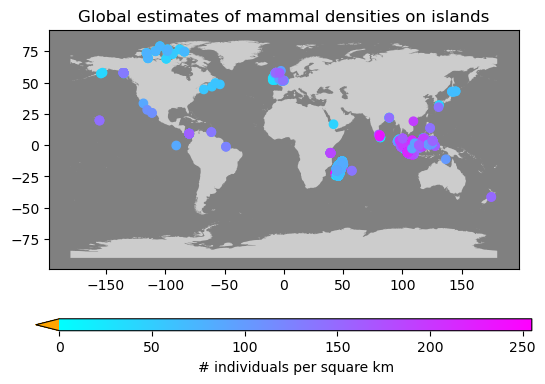

In [27]:
fig, ax = plt.subplots(1,1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

ax.set_facecolor('Gray')
ax.set(title = 'Global estimates of mammal densities on islands')
cmap = mpl.cm.get_cmap('cool')
cmap.set_under('orange')

land_reprojected.plot(ax = ax, edgecolor = 'none', color = '#cccccc', zorder = 0)
mammals.plot(c = mammals.Density,
             ax = ax, 
             zorder = 1, 
             cmap = cmap)

#create a colorbar that shows the scale of density values with assurance there 
#are no values below 0 (which would be noted by an orange color)
scatter = ax.collections[1]
plt.colorbar(scatter, cax = cax, orientation = 'horizontal', label = '# individuals per square km', extend = 'min');




Let's create a zoomed in version of this map that just shows the area around Indonesia, which appears to have a high concentration of datapoints.

In [18]:
# create a custom polygon to clip to extent

polygon = Polygon([(85, -10), (85, 20), (140, 20), (140, -10), (85, -10)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=land.crs)

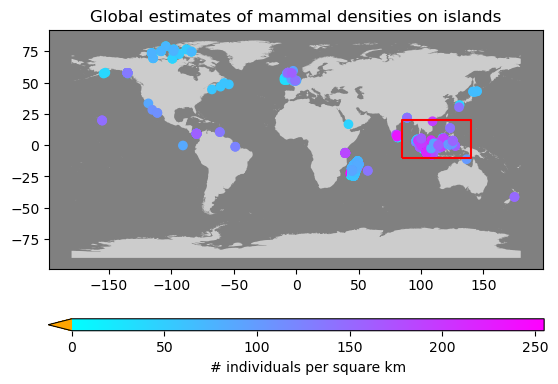

In [19]:
# plot the custom polygon with the rest of the data to ensure it is placed correctly

fig, ax = plt.subplots(1,1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

ax.set_facecolor('Gray')
ax.set(title = 'Global estimates of mammal densities on islands')
cmap = mpl.cm.get_cmap('cool')
cmap.set_under('orange')

land_reprojected.plot(ax = ax, edgecolor = 'none', color = '#cccccc', zorder = 0)
mammals.plot(c = mammals.Density,
             ax = ax, 
             zorder = 1, 
             cmap = cmap)
poly_gdf.boundary.plot(ax=ax, color="red", zorder = 2)

scatter = ax.collections[1]
plt.colorbar(scatter, cax = cax, orientation = 'horizontal', label = '# individuals per square km', extend = 'min');

### Clip data to the extent of interest

In [20]:
land_indonesia = land.clip(polygon)

C:\Users\Kimberly\miniconda3\envs\map674_07\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [21]:
mammals_indonesia = mammals.clip(polygon)

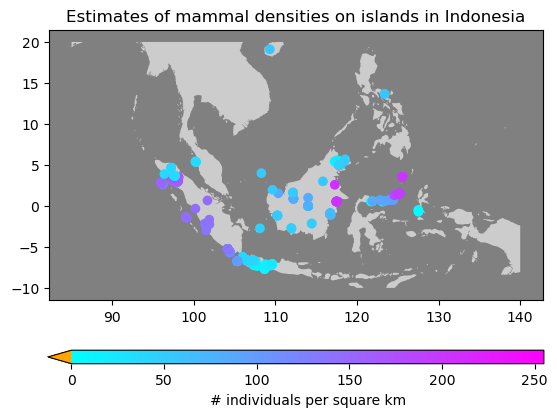

In [22]:
fig, ax = plt.subplots(1,1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

ax.set_facecolor('Gray')
ax.set(title = 'Estimates of mammal densities on islands in Indonesia')
cmap = mpl.cm.get_cmap('cool')
cmap.set_under('orange')

land_indonesia.plot(ax = ax, edgecolor = 'none', color = '#cccccc', zorder = 0)
mammals_indonesia.plot(c = mammals_indonesia.Density,
             ax = ax, 
             zorder = 1, 
             cmap = cmap)

scatter = ax.collections[1]
plt.colorbar(scatter, cax = cax, orientation = 'horizontal', label = '# individuals per square km', extend = 'min');

Let's add some extra information to this plot. Does it look like there could be differences in densities in Primary versus Secondary consumers?

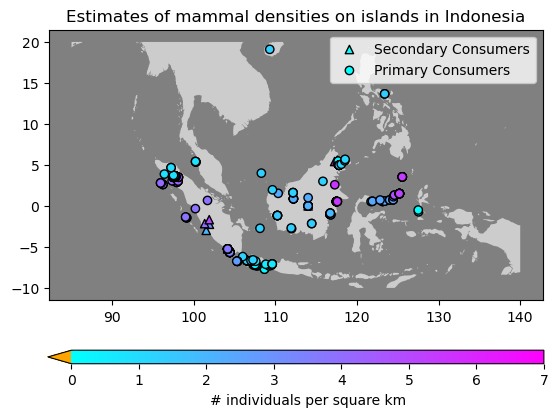

In [23]:
fig, ax = plt.subplots(1,1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

ax.set_facecolor('Gray')
ax.set(title = 'Estimates of mammal densities on islands in Indonesia')
cmap = mpl.cm.get_cmap('cool')
cmap.set_under('orange')

land_indonesia.plot(ax = ax, edgecolor = 'none', color = '#cccccc', zorder = 0)
mammals_indonesia[mammals_indonesia["Order_"] == 'Carnivora'].plot(c = mammals_indonesia.Density,
             ax = ax, 
             zorder = 1, 
             cmap = cmap, marker = '^', edgecolor = 'black', linewidth = 1, label = 'Secondary Consumers')
mammals_indonesia[mammals_indonesia["Order_"] != 'Carnivora'].plot(c = mammals_indonesia.Density,
             ax = ax, 
             zorder = 1, 
             cmap = cmap, marker = 'o', edgecolor = 'black', linewidth = 1, label = 'Primary Consumers')
ax.legend(loc = 'upper right')
scatter = ax.collections[1]
plt.colorbar(scatter, cax = cax, orientation = 'horizontal', label = '# individuals per square km', extend = 'min');

### Write clipped data to a shapefile

In [24]:
# write clipped data to shapefile
# this will reduce the column names to less than 10 characters, per ESRI specifications.

mammals_indonesia.to_file('data/mammals_indonesia')

C:\Users\Kimberly\AppData\Local\Temp\ipykernel_22464\175541029.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mammals_indonesia.to_file('data/mammals_indonesia')


In [25]:
#read shapefile back in

mammals_indo = gpd.read_file('data/mammals_indonesia/mammals_indonesia.shp')
mammals_indo.head()

,OID_,Class,Order_,Family,Genus,Species,Subspecies,Longitude,Latitude,Locality,...,Habitat,Sampling_A,Sampling_1,Density,Density_un,Sampling_M,Method_inf,land_type,scientific,geometry
0,163,Mammalia,Primates,Cercopithecidae,Macaca,nigra,None,127.533333299999995,-0.716666667000000,Bacan,...,None,1.2,km2,170.3,ind/km2,Incomplete_counts,Fixed width transects,big island,Macaca nigra,POINT (127.53333 -0.71667)
1,164,Mammalia,Primates,Cercopithecidae,Macaca,nigra,None,127.500000000000000,-0.500000000000000,Bacan,...,None,1.05,km2,133.9,ind/km2,Incomplete_counts,Fixed width transects,big island,Macaca nigra,POINT (127.50000 -0.50000)
2,613,Mammalia,Primates,Tarsiidae,Tarsius,tarsier,None,121.712000000000003,0.527000000000000,Tanjong Panjang (Sulawesi),...,None,NA,NA,400,ind/km2,Census,audio census,big island,Tarsius tarsier,POINT (121.71200 0.52700)
3,615,Mammalia,Primates,Tarsiidae,Tarsius,tarsier,None,123.132999999999996,0.550000000000000,Dumoga-bone (Sulawesi),...,None,NA,NA,600,ind/km2,Census,audio census,big island,Tarsius tarsier,POINT (123.13300 0.55000)
4,611,Mammalia,Primates,Tarsiidae,Tarsius,tarsier,None,123.132999999999996,0.550000000000000,Dumoga-bone (Sulawesi),...,None,NA,NA,800,ind/km2,Census,audio census,big island,Tarsius tarsier,POINT (123.13300 0.55000)


### Write clipped data to json for webmapping

In [26]:
# write clipped and shaped data to json

with open('../map/data/mammals_indo.json', 'w') as f: f.write(mammals_indo.to_json())

<AxesSubplot: >

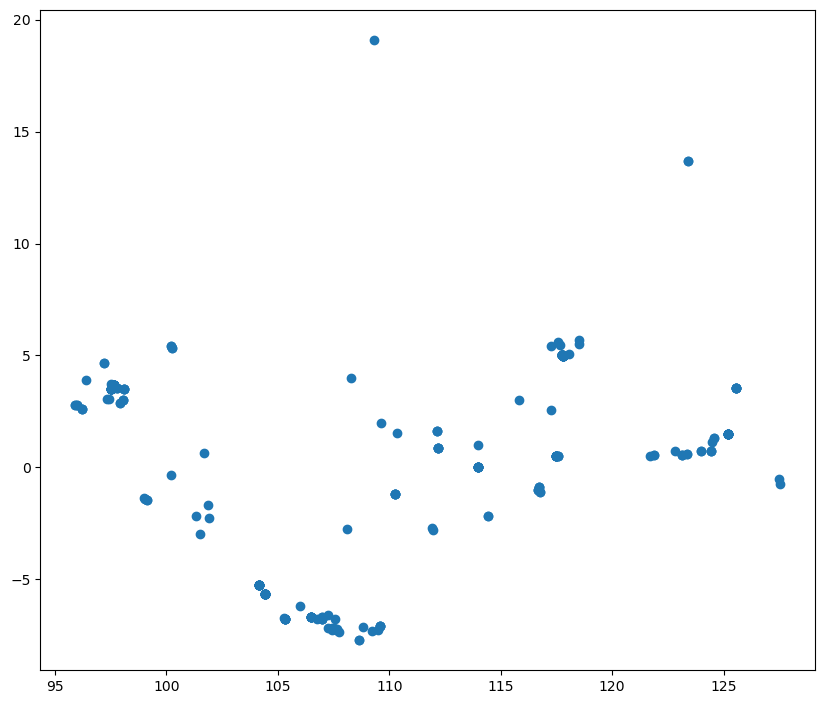

In [60]:
# check that clipped data reads back in correctly

mammals_indo_validate = gpd.read_file('../map/data/mammals_indo.json')
mammals_indo_validate.plot(figsize = (10,10))